<a href="https://colab.research.google.com/github/HJY-429/Machine-Learning/blob/cse446/PyTorch_Neural_Networks_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from torchvision import transforms
import torchvision.utils
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 26099936.56it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 4221344.22it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 13448500.53it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10280911.37it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Constructing the DataLoader

The PyTorch [DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) class is an efficient implementation of an iterator that can perform useful preprocessing and returns batches of elements. Here, we use its ability to batch and shuffle data, but DataLoaders are capable of much more.

Note that each time we iterate over a DataLoader, it starts again from the beginning.

Below we use `torchvision.utils.make_grid()` to show a sample batch of inputs.

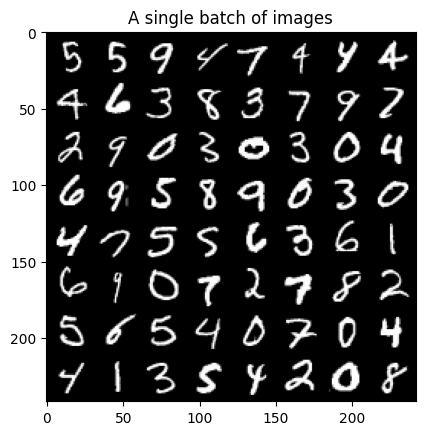

In [ ]:
data_loader = torch.utils.data.DataLoader(mnist, batch_size=64, shuffle=True)

# Show one batch of images. Each batch of images has shape [batch_size, 1, 28, 28],
# where 1 is the "channels" dimension of the image.
for images,labels in data_loader:
    grid_img = torchvision.utils.make_grid(images)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.title("A single batch of images")
    break

### Defining the Network
Here we define a simple 1-hidden-layer neural network for classification on MNIST. It takes a parameter that determines the hidden size of the hidden layer.

In [ ]:
class MNISTNetwork(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.linear_0 = nn.Linear(784, hidden_size)
        self.linear_1 = nn.Linear(hidden_size, 10)

    def forward(self, inputs):
        x = self.linear_0(inputs)
        x = torch.sigmoid(x)
        return self.linear_1(x)

### Instantiating the Networks

We will consider three networks.

1. One that only has a single hidden unit and all of its weights are initialized to exactly 0.
2. One that has 64 hidden units and all of its weights are initialized to exactly 0.
3. One that has 64 hidden units and the weights are initialized using Torch's default, [Kaiming Uniform initialization](https://pytorch.org/docs/stable/nn.init.html).

In the code below, we utilize some important PyTorch methods which you'll want to be familiar with. This includes:

* [`torch.nn.Module.parameters()`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html): Returns an iterator over module parameters (i.e. for passing to an optimizer that will update those parameters).

* [`torch.Tensor.view()`](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html): Returns a *view* into the original Tensor. The result of this method shares the same underlying data as the input Tensor. This avoids copying the data, which means it can be mnore efficient, but it also means that when the original Tensor is modified, so is the view!

* [`torch.Tensor.item()`](https://pytorch.org/docs/stable/generated/torch.Tensor.item.html#torch.Tensor.item): Returns the value of a single-element Tensor as a standard Python number. This only works for tensors with one element. For other cases, see `torch.Tensor.tolist()`.

* [`torch.Tensor.backward()`](https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html): Computes the gradients of current tensor wrt the graph leaves (note that this is only called if `Tensor.requires_grad` is True, which is the case by default). After calling this, a Tensor's `.grad` attribute is updated with the current gradients. These are used, for example, when calling `.step()` method of an optimizer.

* [`torch.optim.Optimizer.zero_grad()`](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html): Sets the gradients of all variables to zero. This should be conducted before each step of an optimization procedure (i.e., for each batch of training a DNN). If `.zero_grad()` is not called, gradients accumulate (add) over iterations.

In [ ]:
small_net = MNISTNetwork(1)
large_net = MNISTNetwork(64)
large_net_rand = MNISTNetwork(64)

In [ ]:
for p in zip(small_net.parameters(), large_net.parameters()):
    p1, p2 = p
    p1.data = torch.zeros_like(p1.data)
    p2.data = torch.zeros_like(p2.data)

### Training

We will train all three networks simulateneously using the same learning rate. After each epoch, we print the current loss of each network.

In [ ]:
epochs = 32

optimizer_small = optim.Adam(small_net.parameters(), lr=5e-3)
optimizer_large = optim.Adam(large_net.parameters(), lr=5e-3)
optimizer_large_rand = optim.Adam(large_net_rand.parameters(), lr=5e-3)

for i in range(epochs):
    loss_small_epoch = 0.
    loss_large_epoch = 0.
    loss_large_rand_epoch = 0.

    for batch in tqdm(data_loader):
        images, labels = batch
        images, labels = images, labels

        images = images.view(-1, 784)

        optimizer_small.zero_grad()
        optimizer_large.zero_grad()
        optimizer_large_rand.zero_grad()

        y_small = small_net(images)
        y_large = large_net(images)
        y_large_rand = large_net_rand(images)

        loss_small = F.cross_entropy(y_small, labels)
        loss_large = F.cross_entropy(y_large, labels)
        loss_large_rand = F.cross_entropy(y_large_rand, labels)

        loss_small_epoch += loss_small.item()
        loss_large_epoch += loss_large.item()
        loss_large_rand_epoch += loss_large_rand.item()

        loss_small.backward()
        loss_large.backward()
        loss_large_rand.backward()

        optimizer_small.step()
        optimizer_large.step()
        optimizer_large_rand.step()

    print("Small Loss:", loss_small_epoch / len(data_loader))
    print("Large Loss:", loss_large_epoch / len(data_loader))
    print("Large rand Loss:", loss_large_rand_epoch / len(data_loader))

100%|██████████| 938/938 [00:19<00:00, 47.39it/s]


Small Loss: 1.972657928715891
Large Loss: 1.8232563129111903
Large rand Loss: 0.32483398939357766


100%|██████████| 938/938 [00:11<00:00, 82.80it/s]


Small Loss: 1.8148071049118855
Large Loss: 1.6486473682084317
Large rand Loss: 0.1464323094233807


100%|██████████| 938/938 [00:11<00:00, 81.65it/s]


Small Loss: 1.7780849990814225
Large Loss: 1.6046347760442476
Large rand Loss: 0.10862547607282236


100%|██████████| 938/938 [00:11<00:00, 84.27it/s]


Small Loss: 1.7257042623786276
Large Loss: 1.5841532197079933
Large rand Loss: 0.08459845937883803


100%|██████████| 938/938 [00:16<00:00, 57.84it/s]


Small Loss: 1.6763492052488997
Large Loss: 1.5767815880683949
Large rand Loss: 0.06969004041894572


100%|██████████| 938/938 [00:12<00:00, 74.35it/s]


Small Loss: 1.6486680498763697
Large Loss: 1.574009679273756
Large rand Loss: 0.05857928107871906


100%|██████████| 938/938 [00:12<00:00, 77.30it/s]


Small Loss: 1.6251971201856
Large Loss: 1.568655116852921
Large rand Loss: 0.05052128520685989


100%|██████████| 938/938 [00:12<00:00, 77.49it/s]


Small Loss: 1.6059556035344789
Large Loss: 1.5685428215750754
Large rand Loss: 0.042452141352897405


100%|██████████| 938/938 [00:10<00:00, 86.28it/s]


Small Loss: 1.5937691252114676
Large Loss: 1.5682913566957404
Large rand Loss: 0.03715998829672061


100%|██████████| 938/938 [00:12<00:00, 77.57it/s]


Small Loss: 1.579385819973976
Large Loss: 1.5676406662601399
Large rand Loss: 0.03108569839907222


100%|██████████| 938/938 [00:10<00:00, 88.89it/s]


Small Loss: 1.575221383114105
Large Loss: 1.567165781312914
Large rand Loss: 0.027473757651682668


100%|██████████| 938/938 [00:10<00:00, 86.03it/s]


Small Loss: 1.5717563402932335
Large Loss: 1.5677270185210304
Large rand Loss: 0.026139781573913428


100%|██████████| 938/938 [00:11<00:00, 80.53it/s]


Small Loss: 1.5672091370198264
Large Loss: 1.5670099089394753
Large rand Loss: 0.02197428221783555


100%|██████████| 938/938 [00:12<00:00, 73.97it/s]


Small Loss: 1.5641782188466362
Large Loss: 1.5651162376027625
Large rand Loss: 0.018281777162412142


100%|██████████| 938/938 [00:11<00:00, 80.40it/s]


Small Loss: 1.561837232697493
Large Loss: 1.567449152469635
Large rand Loss: 0.018439538469081366


100%|██████████| 938/938 [00:12<00:00, 75.65it/s]


Small Loss: 1.5598096154900247
Large Loss: 1.5670212359824922
Large rand Loss: 0.017013064379649816


100%|██████████| 938/938 [00:11<00:00, 82.51it/s]


Small Loss: 1.5581500545493576
Large Loss: 1.5674900809076548
Large rand Loss: 0.016114182745368143


100%|██████████| 938/938 [00:11<00:00, 82.48it/s]


Small Loss: 1.556324137680566
Large Loss: 1.5664251308197152
Large rand Loss: 0.013975212222855932


100%|██████████| 938/938 [00:11<00:00, 83.60it/s]


Small Loss: 1.5570707176285765
Large Loss: 1.5634688179630207
Large rand Loss: 0.013937978338960783


100%|██████████| 938/938 [00:11<00:00, 83.50it/s]


Small Loss: 1.5550513597947957
Large Loss: 1.5676737911919796
Large rand Loss: 0.011304628736654004


100%|██████████| 938/938 [00:11<00:00, 79.46it/s]


Small Loss: 1.554124400686862
Large Loss: 1.5646680396502968
Large rand Loss: 0.01203557449472529


100%|██████████| 938/938 [00:10<00:00, 85.32it/s]


Small Loss: 1.5541318131408204
Large Loss: 1.5669026392609327
Large rand Loss: 0.01353917248794801


100%|██████████| 938/938 [00:10<00:00, 86.10it/s]


Small Loss: 1.5523651411284263
Large Loss: 1.5636695369220237
Large rand Loss: 0.008260446673301863


100%|██████████| 938/938 [00:10<00:00, 85.61it/s]


Small Loss: 1.552933035628882
Large Loss: 1.5619429094450814
Large rand Loss: 0.010053158951599634


100%|██████████| 938/938 [00:10<00:00, 85.85it/s]


Small Loss: 1.5515945824478734
Large Loss: 1.5672007905903147
Large rand Loss: 0.011617213240878627


100%|██████████| 938/938 [00:11<00:00, 80.34it/s]


Small Loss: 1.5498914535620065
Large Loss: 1.5636857760740495
Large rand Loss: 0.007301667430266519


100%|██████████| 938/938 [00:11<00:00, 79.17it/s]


Small Loss: 1.5516649606639643
Large Loss: 1.5641269641898587
Large rand Loss: 0.010897699082808902


100%|██████████| 938/938 [00:11<00:00, 81.55it/s]


Small Loss: 1.548005370697233
Large Loss: 1.566250956388933
Large rand Loss: 0.009783111949747845


100%|██████████| 938/938 [00:11<00:00, 81.87it/s]


Small Loss: 1.549821013834939
Large Loss: 1.5640979230022634
Large rand Loss: 0.009582246128478206


100%|██████████| 938/938 [00:15<00:00, 60.33it/s]


Small Loss: 1.5475979397800177
Large Loss: 1.5602289471290767
Large rand Loss: 0.0059641101819781165


100%|██████████| 938/938 [00:11<00:00, 81.09it/s]


Small Loss: 1.549874745960683
Large Loss: 1.5653120412755368
Large rand Loss: 0.005929951571940184


100%|██████████| 938/938 [00:11<00:00, 82.55it/s]

Small Loss: 1.5483340999719177
Large Loss: 1.5688835934026917
Large rand Loss: 0.009455457166909785


In [ ]:
W_0 = large_net.linear_0.weight
b_0 = large_net.linear_0.bias

W_1 = large_net.linear_1.weight
b_1 = large_net.linear_1.bias

In [ ]:
print("W_0 => All weights equal for each hidden unit:", (W_0[0, :].unsqueeze(0) == W_0).all().item())
print("Example of weights:")
print(W_0[:, 256])

W_0 => All weights equal for each hidden unit: True
Example of weights:
tensor([0.2855, 0.2855, 0.2855, 0.2855, 0.2855, 0.2855, 0.2855, 0.2855, 0.2855,
        0.2855, 0.2855, 0.2855, 0.2855, 0.2855, 0.2855, 0.2855, 0.2855, 0.2855,
        0.2855, 0.2855, 0.2855, 0.2855, 0.2855, 0.2855, 0.2855, 0.2855, 0.2855,
        0.2855, 0.2855, 0.2855, 0.2855, 0.2855, 0.2855, 0.2855, 0.2855, 0.2855,
        0.2855, 0.2855, 0.2855, 0.2855, 0.2855, 0.2855, 0.2855, 0.2855, 0.2855,
        0.2855, 0.2855, 0.2855, 0.2855, 0.2855, 0.2855, 0.2855, 0.2855, 0.2855,
        0.2855, 0.2855, 0.2855, 0.2855, 0.2855, 0.2855, 0.2855, 0.2855, 0.2855,
        0.2855], grad_fn=<SelectBackward0>)


In [ ]:
print("W_1 => All weights equal for each hidden unit:", (W_1[:, 0].unsqueeze(-1) == W_1).all().item())
print("Weights:")
print(W_1[8])

W_1 => All weights equal for each hidden unit: True
Weights:
tensor([-0.0785, -0.0785, -0.0785, -0.0785, -0.0785, -0.0785, -0.0785, -0.0785,
        -0.0785, -0.0785, -0.0785, -0.0785, -0.0785, -0.0785, -0.0785, -0.0785,
        -0.0785, -0.0785, -0.0785, -0.0785, -0.0785, -0.0785, -0.0785, -0.0785,
        -0.0785, -0.0785, -0.0785, -0.0785, -0.0785, -0.0785, -0.0785, -0.0785,
        -0.0785, -0.0785, -0.0785, -0.0785, -0.0785, -0.0785, -0.0785, -0.0785,
        -0.0785, -0.0785, -0.0785, -0.0785, -0.0785, -0.0785, -0.0785, -0.0785,
        -0.0785, -0.0785, -0.0785, -0.0785, -0.0785, -0.0785, -0.0785, -0.0785,
        -0.0785, -0.0785, -0.0785, -0.0785, -0.0785, -0.0785, -0.0785, -0.0785],
       grad_fn=<SelectBackward0>)


In [ ]:
print("b_0 => All biases equal for each hidden unit:", (b_0[0] == b_0).all().item())
print("Bias:")
print(b_0)

b_0 => All biases equal for each hidden unit: True
Bias:
Parameter containing:
tensor([-1.7618, -1.7618, -1.7618, -1.7618, -1.7618, -1.7618, -1.7618, -1.7618,
        -1.7618, -1.7618, -1.7618, -1.7618, -1.7618, -1.7618, -1.7618, -1.7618,
        -1.7618, -1.7618, -1.7618, -1.7618, -1.7618, -1.7618, -1.7618, -1.7618,
        -1.7618, -1.7618, -1.7618, -1.7618, -1.7618, -1.7618, -1.7618, -1.7618,
        -1.7618, -1.7618, -1.7618, -1.7618, -1.7618, -1.7618, -1.7618, -1.7618,
        -1.7618, -1.7618, -1.7618, -1.7618, -1.7618, -1.7618, -1.7618, -1.7618,
        -1.7618, -1.7618, -1.7618, -1.7618, -1.7618, -1.7618, -1.7618, -1.7618,
        -1.7618, -1.7618, -1.7618, -1.7618, -1.7618, -1.7618, -1.7618, -1.7618],
       requires_grad=True)


In [ ]:
print("b_1 => All biases equal for each hidden unit:", (b_1[0] == b_1).all().item())
print("Bias:")
print(b_1)

b_1 => All biases equal for each hidden unit: False
Bias:
Parameter containing:
tensor([ 1.8087, -2.5001, -4.3355,  1.0063,  2.7492,  1.4726, -6.4397,  3.8848,
         0.5805,  3.8672], requires_grad=True)


## Tensor and Layer sizes

Below is an implementation of the network from the section handout. We use `torchinfo-summary()` to view the size of the data as it flows through the network; additionally, we print and the size of the weights and biases of the layers during a forward pass. Note that this network is just for demonstration and may not work well in practice.

*Note:* this section uses the [`torchinfo`](https://github.com/TylerYep/torchinfo) package; see the github repo for installation instructions or run one of the following lines below:

*install via conda*:
```
conda install -c conda-forge torchinfo
```

*install via pip*:
```
pip install torchinfo
```

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

class DemoNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 16, 3, 1, 1)
        self.max1 = nn.MaxPool2d(2, 2, 0)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 0)
        self.max2 = nn.MaxPool2d(2, 2, 1)
        self.conv3 = nn.Conv2d(32, 8, 1, 1, 0)
        self.conv4 = nn.Conv2d(8, 4, 5, 1, 0)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(36, 10)

    @property
    def trainable_layers(self):
        """A utility property to easily access a list of all model layers."""
        return [self.conv1, self.conv2, self.conv3, self.conv4, self.linear1]

    def forward(self, inputs):
        """Implements the forward pass."""
        x = self.conv1(inputs)
        x = self.max1(x)
        x = self.conv2(x)
        x = self.max2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        x = self.linear1(x)
        return x

    def print_weight_shapes(self):
        """Utility function to print the shapes of weights in trainable layers."""
        for layer in self.trainable_layers:
            print(f"Weight shape: {layer.weight.shape}; Bias shape: {layer.bias.shape}")

demo = DemoNetwork()
batch_size = 64
summary(demo, input_size=(batch_size, 1, 28, 28))


Layer (type:depth-idx)                   Output Shape              Param #
DemoNetwork                              [64, 10]                  --
├─Conv2d: 1-1                            [64, 16, 28, 28]          160
├─MaxPool2d: 1-2                         [64, 16, 14, 14]          --
├─Conv2d: 1-3                            [64, 32, 12, 12]          4,640
├─MaxPool2d: 1-4                         [64, 32, 7, 7]            --
├─Conv2d: 1-5                            [64, 8, 7, 7]             264
├─Conv2d: 1-6                            [64, 4, 3, 3]             804
├─Flatten: 1-7                           [64, 36]                  --
├─Linear: 1-8                            [64, 10]                  370
Total params: 6,238
Trainable params: 6,238
Non-trainable params: 0
Total mult-adds (M): 52.11
Input size (MB): 0.20
Forward/backward pass size (MB): 9.01
Params size (MB): 0.02
Estimated Total Size (MB): 9.23

In [ ]:
demo.print_weight_shapes()

Weight shape: torch.Size([16, 1, 3, 3]); Bias shape: torch.Size([16])
Weight shape: torch.Size([32, 16, 3, 3]); Bias shape: torch.Size([32])
Weight shape: torch.Size([8, 32, 1, 1]); Bias shape: torch.Size([8])
Weight shape: torch.Size([4, 8, 5, 5]); Bias shape: torch.Size([4])
Weight shape: torch.Size([10, 36]); Bias shape: torch.Size([10])


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_data, test_data = torch.utils.data.random_split(mnist, [0.9, 0.1])
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

epochs = 16
optimizer = optim.Adam(demo.parameters(), lr=5e-3)

for i in range(epochs):
    loss = 0.
    correct_labels = 0
    total_labels = 0

    for batch in tqdm(train_dataloader):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        y_hat = demo(images)
        batch_loss = F.cross_entropy(y_hat, labels)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        correct_labels += torch.sum(torch.argmax(y_hat, dim=1) == labels).item()
        total_labels += len(labels)

    print("Train Loss:", loss / len(data_loader))
    print("Train Accuracy:", correct_labels / total_labels)


100%|██████████| 844/844 [00:11<00:00, 74.49it/s]


Train Loss: 0.20208556863314497
Train Accuracy: 0.9303888888888889


100%|██████████| 844/844 [00:15<00:00, 54.19it/s] 


Train Loss: 0.08882212595118563
Train Accuracy: 0.9698333333333333


100%|██████████| 844/844 [00:09<00:00, 90.74it/s] 


Train Loss: 0.07638853172690216
Train Accuracy: 0.9747777777777777


100%|██████████| 844/844 [00:09<00:00, 88.07it/s]


Train Loss: 0.06875016951267279
Train Accuracy: 0.9767962962962963


100%|██████████| 844/844 [00:10<00:00, 83.33it/s]


Train Loss: 0.06605510008824207
Train Accuracy: 0.9776666666666667


100%|██████████| 844/844 [00:11<00:00, 73.52it/s] 


Train Loss: 0.0616874150512467
Train Accuracy: 0.978462962962963


100%|██████████| 844/844 [00:09<00:00, 91.21it/s]


Train Loss: 0.05907304961157879
Train Accuracy: 0.9799814814814815


100%|██████████| 844/844 [00:09<00:00, 89.98it/s]


Train Loss: 0.05784383848136569
Train Accuracy: 0.9802407407407407


100%|██████████| 844/844 [00:08<00:00, 98.65it/s]


Train Loss: 0.055566642120026793
Train Accuracy: 0.9806111111111111


100%|██████████| 844/844 [00:09<00:00, 91.00it/s] 


Train Loss: 0.05358309810003787
Train Accuracy: 0.9812037037037037


100%|██████████| 844/844 [00:09<00:00, 90.69it/s]


Train Loss: 0.05091548204878226
Train Accuracy: 0.9822407407407407


100%|██████████| 844/844 [00:09<00:00, 90.85it/s]


Train Loss: 0.05342959099226315
Train Accuracy: 0.9818888888888889


100%|██████████| 844/844 [00:08<00:00, 100.69it/s]


Train Loss: 0.049255100912916516
Train Accuracy: 0.9829444444444444


100%|██████████| 844/844 [00:09<00:00, 92.15it/s] 


Train Loss: 0.05195553839237847
Train Accuracy: 0.9823518518518518


100%|██████████| 844/844 [00:09<00:00, 93.14it/s] 


Train Loss: 0.04872350302456108
Train Accuracy: 0.9827777777777778


100%|██████████| 844/844 [00:08<00:00, 99.12it/s]

Train Loss: 0.04858209256520634
Train Accuracy: 0.9834259259259259


In [ ]:
with torch.no_grad():
    loss = 0.
    correct_labels = 0
    total_labels = 0
    for batch in tqdm(test_dataloader):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        y_hat = demo(images)
        batch_loss = F.cross_entropy(y_hat, labels)

        loss += batch_loss.item()
        correct_labels += torch.sum(torch.argmax(y_hat, dim=1) == labels).item()
        total_labels += len(labels)

    print("Test Loss:", loss / len(data_loader))
    print("Test Accuracy:", correct_labels / total_labels)

100%|██████████| 94/94 [00:01<00:00, 91.87it/s]

Test Loss: 0.007584880548324545
Test Accuracy: 0.9803333333333333
